In [1]:
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import jax
import jax.numpy as jnp
import random

In [3]:
import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd = tfp.distributions

In [4]:
from collections import namedtuple

In [5]:
%load_ext autoreload
%autoreload 2
import rethinking

In [6]:
from rethinking.data import RethinkingDataset
from rethinking.data import dataframe_to_tensors
from rethinking.mcmc import sample_posterior

In [7]:
# a function to plot the density using arviz plot_kde function
def plot_density(positions, x_label="Position", y_label="Density"):
    az.plot_kde(positions)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

In [8]:
plt.rcParams['figure.figsize'] = [6, 4]

In [9]:
# generate a key
# jax.random.key (new version of jax.random.PRNGKey) 
#   not working with tfp.substrates.jax.mcmc
def a_key():
    # return jax.random.key(random.randint(0, 1000_000))
    return jax.random.PRNGKey(random.randint(0, 1000_000))

In [ ]:
# jnp array replaces tf array
# but jnp has yet no equivalant to tf.Variable() 
from tensorflow_probability.python.internal.backend import jax as tf

In [ ]:
tf.Variable(3)

## 4.1 Why normal distributions are normal

### 4.1.1 Normal by addition

##### Code 4.1

This snippet is showing the notion of "Normal distribution by Addition"

In [ ]:
u1 = tfd.Uniform(low=-1.0, high=1.0)
pos = jnp.sum(u1.sample(sample_shape=(16, 1000), seed=a_key()), axis=0)
plot_density(pos)

### 4.1.2 Normal by multiplication

##### Code 4.2 & 4.3

This snippet is showing the notion of "Normal distribution by Multiplication"

In [ ]:
u2 = tfd.Uniform(low=1.0, high=1.1)
pos = jnp.prod(u2.sample(sample_shape=(12, 10000), seed=a_key()), axis=0)
plot_density(pos)

##### Code 4.4

Continuation of the notion of "Normal distribution by Multiplication"

Author explains that - "The smaller the effect of a variable (locus in the example), the better the additive approximation will be"

In [ ]:
big = jnp.prod(tfd.Uniform(low=1.0, high=1.5).sample(sample_shape=(12, 10000), 
                                                     seed=a_key()), axis=0)
small = jnp.prod(tfd.Uniform(low=1.0, high=1.01).sample(sample_shape=(12, 10000), 
                                                        seed=a_key()), axis=0)

_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(big, ax=ax[0])
az.plot_kde(small, ax=ax[1]);

### 4.1.3 Normal by log-multiplication

##### Code 4.5

This snippet is showing the notion of "Normal distribution by log-multiplication"

Author explains - "Large deviates that are multi- plied together do not produce Gaussian distributions, but they do tend to produce Gaussian distributions on the log scale. So even multiplicative interactions of large deviations can produce Gaussian distributions, once we measure the outcomes on the log scale."

In [ ]:
log_big = jnp.log(
  jnp.prod(
    tfd.Uniform(low=1.0, high=1.5).sample(sample_shape=(12, 10000), 
                                          seed=a_key()), axis=0))

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(big, ax=ax[0])
az.plot_kde(log_big, ax=ax[1])

## 4.2 A language for describing models

##### Code 4.6

Here the globe tossing model is described again.

$w$ = Observed count of water

$n$ = Total number of tosses

$p$ = Proportion of water on the globel


This is the first introduction/usage of Bayes' Theorem


In [ ]:
w, n = 6.0, 9.0

p_grid = jnp.linspace(0.0, 1.0, 100)

b1_dist = tfd.Binomial(total_count=n, probs=p_grid)
u3_dist = tfd.Uniform(low=0.0, high=1.0)

posterior = b1_dist.prob(w) * u3_dist.prob(p_grid)
posterior = posterior / jnp.sum(posterior)

plt.plot(p_grid, posterior)
plt.xlabel("p")
plt.ylabel("Density")

## 4.3 Gaussian model of height

### 4.3.1 The data

##### Code 4.7, 4.8 


We are now building the Gaussian model of height


In [ ]:
d = RethinkingDataset.Howell1.get_dataset()
d.head()

##### Code 4.9

In [ ]:
az.summary(d.to_dict(orient="list"), kind="stats", hdi_prob=0.89)

##### Code 4.10

For now we are going to work only with the height columns so let's look at it

In [ ]:
d.height.head()

##### Code 4.11

We are only interested in the heights of adults only (for the time being; we will incorporate the whole dataset later)

In [ ]:
d2 = d[d.age >= 18]

### 4.3.2 The model

##### Code 4.12 & 4.13

Author explains that whatever is your prior, it's a very good idea to always plot it. This way we will have a better
sense of our model.

Here we have assumed certain values for our priors and as per the instruction plotting them

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

x = jnp.linspace(100.0, 250.0, 100)
mu_prior = tfd.Normal(loc=178.0, scale=20.0)
ax1.set_title("Prior for mu")
ax1.plot(x, mu_prior.prob(x))

x = jnp.linspace(-10.0, 60.0, 100)
scale_prior = tfd.Uniform(low=0.0, high=50.0)
ax2.set_title("Prior for scale/sigma")
ax2.plot(x, scale_prior.prob(x))

##### Code 4.14

In the above section we have chosen priors for $h$, $\mu$, $\sigma$ and even plotted them. It is also important to now see what kind of distribution these assumptions generate. This is called **PRIOR PREDICTIVE simulation** and is important part of modelling.

In [ ]:
# plot the joint distribution of h, mu and sigma
n_samples = 1000

sample_mu = tfd.Normal(loc=178.0, scale=20.0).sample(n_samples, seed=a_key())
sample_sigma = tfd.Uniform(low=0.0, high=50.0).sample(n_samples, seed=a_key())
prior_h = tfd.Normal(loc=sample_mu, scale=sample_sigma).sample(seed=a_key())

az.plot_kde(prior_h)

##### Code 4.15

As mentioned in above cell the prior predictive simulation is helpful in assigning sensible priors. Here we see if we change the scale for *sample_mu* to 100 (instead of using 20 as in the above cell)

In [ ]:
# plot the joint distribution of h, mu and sigma
n_samples = 1000

sample_mu = tfd.Normal(loc=178.0, scale=100.0).sample(n_samples, seed=a_key())
sample_sigma = tfd.Uniform(low=0.0, high=50.0).sample(n_samples, seed=a_key())
prior_h = tfd.Normal(loc=sample_mu, scale=sample_sigma).sample(seed=a_key())

az.plot_kde(prior_h)

Now, what the above plot is showing that there are about 4% of people that have a **negative height** and about 18% on the right side have height not common at all for humans to attain ! So clearly this choice of scale (i.e. 100) is not a good one as the prior. 

### 4.3.3 Grid approximation of the posterior distribution

##### Code 4.16

Here we are doing **Grid approximation of the posterior distribution**. A very crude technique that may work for small/simple models. It is customary to do it to make a point but later we will use well established inference methods based on MCMC and VI

In [ ]:
def compute_likelihood(mu, sigma, sample_data):
    def _compute(mu, sigma, sample_data):
        norm_dist = tfd.Normal(loc=mu, scale=sigma)
        return jnp.sum(norm_dist.log_prob(sample_data))

    return jax.vmap(_compute, in_axes=(0, 0, None))(mu, sigma, sample_data)


def grid_approximation(sample_data, mu_start=150.0, mu_stop=160.0, 
                       sigma_start=7.0, sigma_stop=9.0):
    mu_list = jnp.linspace(start=mu_start, stop=mu_stop, num=200)
    sigma_list = jnp.linspace(start=sigma_start, stop=sigma_stop, num=200)

    mesh = jnp.meshgrid(mu_list, sigma_list)
    mu = jnp.reshape(mesh[0], -1)
    sigma = jnp.reshape(mesh[1], -1)

    log_likelihood = compute_likelihood(mu, sigma, sample_data)

    logprob_mu = tfd.Normal(178.0, 20.0).log_prob(mu)
    logprob_sigma = tfd.Uniform(low=0.0, high=50.0).log_prob(sigma)

    log_joint_prod = log_likelihood + logprob_mu + logprob_sigma
    joint_prob = jnp.exp(log_joint_prod - jnp.max(log_joint_prod))

    return mesh, joint_prob

In [ ]:
mesh, joint_prob = grid_approximation(d2.height.values)

##### Code 4.17

Make a contour plot

In [ ]:
reshaped_joint_prob = jnp.reshape(joint_prob, (200, 200))
plt.contour(*mesh, reshaped_joint_prob)

##### Code 4.18

Here we are plotting a heatmap instead of contour plot

In [ ]:
plt.imshow(reshaped_joint_prob, origin="lower", extent=(150, 160, 7, 9), aspect="auto")

### 4.3.4 Sampling from the posterior

##### Code 4.19 & 4.20

We are at point of now **Sampling from the Posterior**

In [ ]:
joint_prob.shape, joint_prob[:10]

In [ ]:
# This is a trick to sample row numbers randomly with the help of Categorical distribution
sample_rows = tfd.Categorical(probs=(joint_prob / jnp.sum(joint_prob))).sample(
  100_00, seed=a_key())
sample_rows

In [ ]:
mu = mesh[0].reshape(-1)
sigma = mesh[1].reshape(-1)

# We are sampling 2 parameters here from the selected rows
sample_mu = mu[sample_rows]
sample_sigma = sigma[sample_rows]

plt.scatter(sample_mu, sample_sigma, s=64, alpha=0.1, edgecolor="none")

##### Code 4.21

Time to summarize/describe the distribution of confidence in each combination of $\mu$ & $\sigma$ using the samples.

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(sample_mu, ax=ax[0])
ax[0].set_xlabel("sample_mu")
ax[0].set_yticks([])
az.plot_kde(sample_sigma, ax=ax[1])
ax[1].set_xlabel("sample_sigma")
ax[1].set_yticks([])

As should be clear from the plot, the densities here are very close *normal distribution*. As sample size increases, posterior densities show this behavior. 

Pay attention to sample_sigma, density of it has a **longer right-hand tail**. Author mentions here that this condition is very common for standard deviation parameters. No explanation about it at this point of time.

##### Code 4.22

Now we want to summarize the widths of these densities with **posterior compatibility intervals**

In [ ]:
type(sample_mu), type(sample_mu.__array__()), type(jax.device_get(sample_mu))

### 4.3.5 Finding the posterior distribution using quap

### 4.3.5 Finding the posterior distribution using quap

In [ ]:
print("sample_mu -", az.hdi(sample_mu.__array__()))
print("sample_sigma -", az.hdi(jax.device_get(sample_sigma)))

##### Code 4.23 & Code 4.24

Author now wants to use Quadratic approximation but he wants to make a point about using it and impact of $\sigma$ on this approximation.

Here the above analysis of the height data is repeated but with only a fraction of original data. The reasoning behind is to demonstrate that, in principle, the posterior is not always Gaussian in shape.

Author explains that for a Guassian $\mu$ & Gaussian likelihood the shape is always Gaussian irrespective of the sample size but it is the $\sigma$ that causes problems.

In [ ]:
# We just get 20 samples for now and repeat our exercise
d3 = d2.height.sample(n=20)

In [ ]:
mesh2, joint_prob2 = grid_approximation(
    d3.values,
    mu_start=150.0,
    mu_stop=170.0,
    sigma_start=4.0,
    sigma_stop=20.0)

In [ ]:
mu2 = mesh2[0].reshape(-1)
sigma2 = mesh2[1].reshape(-1)

# We are sampling 2 parameters here from the selected rows
sample_mu2 = mu2[sample_rows]
sample_sigma2 = sigma2[sample_rows]

plt.scatter(sample_mu2, sample_sigma2, s=64, alpha=0.1, edgecolor="none")

##### Code 4.25

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(sample_mu2, ax=ax[0])
ax[0].set_xlabel("sample_mu2")
ax[0].set_yticks([])
az.plot_kde(sample_sigma2, ax=ax[1])
ax[1].set_xlabel("sample_sigma2")
ax[1].set_yticks([])

In [ ]:
az.plot_kde(sample_sigma2)
x = jnp.sort(sample_sigma2)
plt.plot(x, tfd.Normal(loc=jnp.mean(x), scale=jnp.std(x)).prob(x), "--")

### 4.3.5 Finding the posterior distribution using quap

##### Code 4.26

We will reload our data frame and start to use quadratic approximiation now

In [10]:
d = RethinkingDataset.Howell1.get_dataset()
d2 = d[d.age > 18]

##### Code 4.27

We are now ready to define our model using tensorflow probability.


There are few ways to define a model using tfp, I am going to use a variant
of JointSequential that uses Coroutines (generator) based syntax. However, you can always
define as a plain function and return log probs yourself. An example of plain function that would be 

```python
def joint_log_prob_model(mu, sigma, data):
  mu_dist = tfd.Normal(loc=178., scale=20.)
  sigma_dist = tfd.Uniform(low=0., high=50.)
  height_dist = tfd.Normal(loc=mu, scale=sigma)
  
  return (
      mu_dist.log_prob(mu) +
      sigma_dist.log_prob(sigma) +           
      tf.reduce_sum(height_dist.log_prob(data)) 
  )
```

##### Code 4.28

In [11]:
n_sample = d2.shape[0]

# using JointDistributionNamedAutoBatched

In [ ]:
m41 = dict(
    mu = tfd.Normal(loc=178.0, scale=20.0),
    sigma = tfd.Uniform(low=0.0, high=50.0),
    height = lambda mu, sigma: tfd.Sample(tfd.Normal(loc=mu, scale=sigma), n_sample)
)

jd_4_1_N = tfd.JointDistributionNamedAutoBatched(m41)

In [ ]:
jd_4_1_N.sample(seed=a_key())

In [ ]:
# sample of 'Named': dictionary
type(jd_4_1_N.sample(seed=a_key()))

In [ ]:
# mcmc.sample_chain(current_state): Tensor or Python list of Tensor
#  - error when dict input 
# a list of two jnp.array
init_state = [jd_4_1_N.sample(seed=a_key())[s] for s in ["mu", "sigma"]]
init_state

In [ ]:
# Match the function args with the init_state
# init_state(a list of two jnp.array) be interpreted as "mu" and "sigma"
def target_log_prob(mu, sigma):
    # sample of 'Named': dictionary
    samples = {"mu": mu, "sigma": sigma, "height": jnp.array(d2["height"])}
    return jd_4_1_N.log_prob(samples)

In [ ]:
kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob,
    step_size=0.2, 
    num_leapfrog_steps=2)

In [ ]:
states = tfp.mcmc.sample_chain(
    1000,
    current_state=init_state,
    kernel=kernel,
    num_burnin_steps=200,
    trace_fn=None,
    seed=a_key())

In [ ]:
states

In [ ]:
states_dict = dict(zip(["mu", "sigma"], states))

In [ ]:
az.summary(states_dict, round_to=2, kind="stats", hdi_prob=0.89)

In [ ]:
# shape of mcmc.sample_chain output depends on shape of init_state
init_state = jnp.concatenate(
  [jnp.expand_dims(s, axis=0) for s in init_state if jnp.ndim(s)==0])
# an jnp.array of two elements
init_state

In [ ]:
# def target_log_prob(mu, sigma):
def target_log_prob(states):
    mu, sigma = states
    states = {"mu": mu, "sigma": sigma, "height": jnp.array(d2["height"])}
    return jd_4_1_N.log_prob(states)

In [ ]:
kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob,
    step_size=0.2, 
    num_leapfrog_steps=2)

In [ ]:
states = tfp.mcmc.sample_chain(
    1000,
    current_state=init_state,
    kernel=kernel,
    num_burnin_steps=200,
    trace_fn=None,
    seed=a_key())

In [ ]:
states

# using JointDistributionCoroutineAutoBatched

In [ ]:
def m41c():
    mu = yield tfd.Normal(loc=178.0, scale=20.0, name="mu")
    sigma = yield tfd.Uniform(low=0.0, high=50.0, name="sigma")
    height = yield tfd.Sample(tfd.Normal(loc=mu, scale=sigma), n_sample, name="height")

jd_4_1_C = tfd.JointDistributionCoroutineAutoBatched(m41c)

In [ ]:
# 'Couroutine' sample: StructTuple
init2 = jd_4_1_C.sample(seed=a_key())
init2

In [ ]:
type(init2)

In [ ]:
# seemingly a NamedTuple
init2.mu, init2.sigma

In [ ]:
init2[:-1]

In [ ]:
# a NamedTuple for Coroutine.log_prob()
StateTuple = namedtuple("StateTuple", ["mu", "sigma", "height"])

In [ ]:
# mcmc.sample_chain() can interpret NamedTuple, so two args needed
def target_log_prob(mu, sigma):
    params = {"mu": mu, "sigma": sigma, "height": jnp.array(d2["height"])}
    return jd_4_1_C.log_prob(StateTuple(**params))

In [ ]:
kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob,
    step_size=0.2, 
    num_leapfrog_steps=2
)

In [ ]:
init2 = init2[:-1]

In [ ]:
states2 = tfp.mcmc.sample_chain(
    1000,
    current_state=init2,
    kernel=kernel,
    num_burnin_steps=200,
    trace_fn=None,
    seed=a_key()
)

In [ ]:
states2

In [ ]:
az.summary(states2._asdict(), round_to=2, kind="stats", hdi_prob=0.89)

These numbers shown above provide Gaussian approximations for each parameter’s marginal distribution.

# a 'jit' version

In [ ]:
# def run_chain(init_state, key):
#     target_log_prob = target_log_prob(...)
#     kernel = tfp.mcmc.HamiltonianMonteCarlo(...)
#     return tfp.mcmc.sample_chain(...)

# states = jax.jit(run_chain)(init_state, key)

In [ ]:
tfd.Sample(tfd.Normal(loc=0., scale=1.), (2,)).sample(seed=a_key())

In [ ]:
jnp.array([[3,2]]).shape

##### Code 4.30

What should be the starting values for the sampling ?

Author recommends that we could use the mean from the dataframe

##### Code 4.31

In [ ]:
model_4_2 = dict(
    # mu = tfd.Normal(loc=178.0, scale=20.0),
    mu = tfd.Normal(loc=178.0, scale=0.1),
    sigma = tfd.Uniform(low=0.0, high=50.0),
    height = lambda mu, sigma: tfd.Sample(tfd.Normal(loc=mu, scale=sigma), n_sample)
)

jdc_4_2 = tfd.JointDistributionNamedAutoBatched(model_4_2)

In [97]:
num_burnin_steps = 0
num_results = 1000
step_size = 0.1

In [98]:
init_state = [jdc_4_2.sample(seed=a_key())[s] for s in ["mu", "sigma"]]

NameError: name 'jdc_4_2' is not defined

In [ ]:
def target_log_prob(mu, sigma):
    samples = {"mu": mu, "sigma": sigma, "height": d2.height.values}
    return jdc_4_2.log_prob(samples)

In [ ]:
kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob,
    step_size=step_size, 
    num_leapfrog_steps=2)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel, num_adaptation_steps=int(num_burnin_steps * 0.8))

In [ ]:
states, [step_size, log_accept_ratio] = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=init_state,
    kernel=kernel,
    num_burnin_steps=num_burnin_steps,
    trace_fn=lambda _, pkr: [pkr.inner_results.accepted_results.step_size,
                             pkr.inner_results.log_accept_ratio],
    seed=a_key())

In [ ]:
jnp.unique(step_size)

In [ ]:
jnp.exp(tfp.math.reduce_logmeanexp(jnp.minimum(log_accept_ratio, 0.)))

In [ ]:
states_dict = dict(zip(["mu", "sigma"], [jax.device_get(s) for s in states]))

In [ ]:
az.summary(states_dict, round_to=2, kind="stats", hdi_prob=0.89)

Taken verbatim from the book :

Notice that the estimate for μ has hardly moved off the prior. The prior was very concentrated around 178. So this is not surprising. But also notice that the estimate for σ has changed quite a lot, even though we didn’t change its prior at all. Once the golem is certain that the mean is near 178—as the prior insists—then the golem has to estimate σ conditional on that fact. This results in a different posterior for σ, even though all we changed is prior information about the other parameter.

In [18]:
d = RethinkingDataset.Howell1.get_dataset()
d2 = d[d.age > 18]

In [22]:
n_sample = d2.shape[0]

In [10]:
m41 = dict(
    mu = tfd.Normal(loc=178.0, scale=20.0),
    sigma = tfd.Uniform(low=0.0, high=50.0),
    height = lambda mu, sigma: tfd.Sample(tfd.Normal(loc=mu, scale=sigma), n_sample)
)

jd_4_1 = tfd.JointDistributionNamedAutoBatched(m41)

In [11]:
state_name = "mu", "sigma"

In [12]:
def target_log_prob_41(mu, sigma):
    sample = dict(zip(state_name, (mu, sigma)), height = d2.height.values)
    return jd_4_1.log_prob(sample)

In [202]:
num_burnin_steps = 500
num_results = 500
step_size = 0.2

In [203]:
kernel_41 = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_41,
    step_size=step_size,
    num_leapfrog_steps=2)

kernel_41 = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel_41, num_adaptation_steps=int(num_burnin_steps * 0.8))

In [ ]:
# - init_state = [jnp.zeros(()), jnp.zeros(())]
#   : stay at zero, bad initial
# - init_state = [jd_4_1.sample((), seed=a_key())[s] for s in state_name]
#   : a safe way

In [219]:
# number of chains: 3
init_state = [jd_4_1.sample((3,), seed=a_key())[s] for s in state_name]
init_state

[Array([176.18478, 177.6693 , 158.44714], dtype=float32),
 Array([47.17114 , 20.272816, 48.890217], dtype=float32)]

In [220]:
states_41 = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=init_state,
    kernel=kernel_41,
    num_burnin_steps=num_burnin_steps,
    trace_fn=None,
    seed=a_key())

states_41

[Array([[154.57205, 153.9963 , 154.06905],
        [154.83511, 155.32802, 155.11101],
        [154.42462, 154.0051 , 155.11101],
        ...,
        [154.7698 , 155.13243, 154.55849],
        [154.2735 , 154.59679, 154.61638],
        [154.93718, 155.01646, 154.49252]], dtype=float32),
 Array([[7.7772555, 7.7579837, 8.052091 ],
        [7.730052 , 7.7755446, 7.418921 ],
        [7.901349 , 8.207008 , 7.418921 ],
        ...,
        [7.3481936, 7.4515285, 7.5669084],
        [8.177907 , 8.0141325, 7.8535037],
        [7.2146044, 7.562487 , 8.149304 ]], dtype=float32)]

In [221]:
# tfp.mcmc.sample_chain output shape: (draws, chains, *shape)
# arvis input shape: (chains, draws, *shape)
states_41 = [jnp.moveaxis(s, 0, 1) for s in states_41]

In [222]:
states_41_dict = dict(zip(state_name, states_41))

In [223]:
# stats for all chains
az.summary(states_41_dict, round_to=2, kind="stats", hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
mu,154.65,0.42,154.02,155.33
sigma,7.80,0.29,7.27,8.22


In [224]:
# stats for the first chains
az.summary(dict(mu=states_41_dict['mu'][0], sigma=states_41_dict['sigma'][0]), 
           round_to=2, kind="stats", hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
mu,154.65,0.43,153.90,155.28
sigma,7.79,0.28,7.33,8.27


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

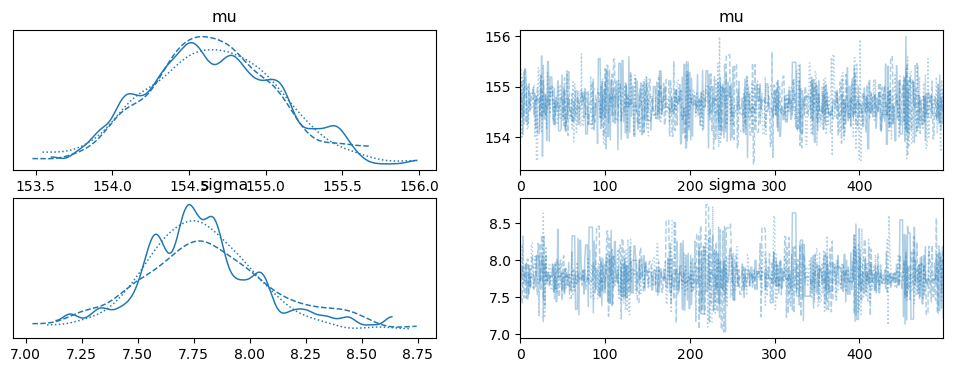

In [225]:
az.plot_trace(states_41_dict)

##### Code 4.32


Now this approximation of posterior is multi-dimension where $\mu$ and $\sigma$ are contributing a dimension each. In other words, we have a multi-dimensional gaussian distribution

Since it is multi-dimensional, let's see the covariances between the parameters

<Axes: xlabel='mu', ylabel='sigma'>

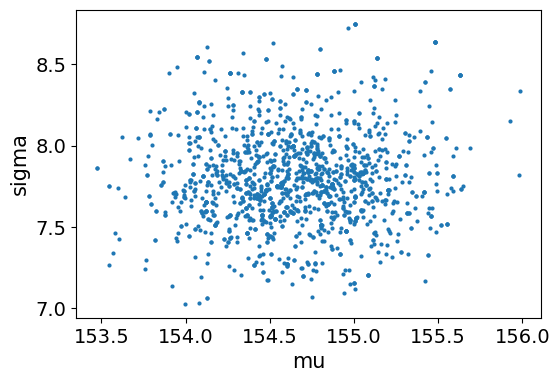

In [226]:
az.plot_pair(states_41_dict)

In [227]:
sample_mu, sample_sigma = states_41_dict['mu'][0], states_41_dict['sigma'][0]
cov_41 = tfp.stats.covariance(jnp.stack([sample_mu, sample_sigma], axis=1))
cov_41

Array([[ 0.18079446, -0.01704215],
       [-0.01704215,  0.07990017]], dtype=float32)

##### Code 4.33

In [228]:
tfp.stats.correlation(jnp.stack([sample_mu, sample_sigma], axis=1))

Array([[ 1.0000004 , -0.14179347],
       [-0.14179347,  0.99999964]], dtype=float32)

##### Code 4.34

We did not use the quadratic approximation, instead we use a MCMC method to sample from the posterior. Thus, we already have samples. We can do something like

In [218]:
jnp.mean(sample_mu), jnp.mean(sample_sigma)

(Array(154.64622, dtype=float32), Array(7.790839, dtype=float32))

In [235]:
mvn = tfd.MultivariateNormalTriL(loc=[jnp.mean(sample_mu), jnp.mean(sample_sigma)], 
                                 scale_tril=jnp.linalg.cholesky(cov_41))
mvn.sample(100, seed=a_key())

Array([[154.50098  ,   7.7300477],
       [154.6439   ,   7.9327946],
       [155.34593  ,   8.030541 ],
       [154.62769  ,   8.027846 ],
       [154.31647  ,   7.634522 ],
       [154.39626  ,   7.5931683],
       [154.67442  ,   7.424571 ],
       [154.83284  ,   7.7629313],
       [154.83205  ,   7.795492 ],
       [154.08733  ,   7.9470053],
       [154.4459   ,   7.7891417],
       [154.67743  ,   7.742563 ],
       [154.41928  ,   7.803641 ],
       [154.48004  ,   7.7641773],
       [154.42233  ,   8.056779 ],
       [154.4794   ,   7.8886795],
       [154.97998  ,   7.5819254],
       [154.32028  ,   7.9458175],
       [153.86667  ,   8.399642 ],
       [154.14557  ,   7.878003 ],
       [154.58357  ,   7.8813534],
       [154.84808  ,   8.079478 ],
       [153.9235   ,   8.0854435],
       [154.41022  ,   7.982163 ],
       [155.05989  ,   7.8688526],
       [154.57812  ,   8.03282  ],
       [154.12888  ,   8.201299 ],
       [153.80489  ,   7.5318017],
       [154.71884  ,